# Обработка звука

В этом семинаре мы сделаем следующие вещи:

* Напишем обработку данных для обучения модели по распознаванию речи.
* Напишем простенькую модель.
* Обучим модель с помощью функции потерь CTC.
* Замерим качество с помощью метрики CER.

In [2]:
!pip install torch==1.7.1 torchaudio==0.7.2

     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 7.6MB 17.6MB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101


In [3]:
# Оформление 
from typing import List, Tuple, Dict, Union, Optional

# Картинки
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format ='retina'

from IPython.display import clear_output

# Фиксируем размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    "font.sans-serif": ["Benton Sans"]})

# Аудио
from IPython import display
import torchaudio


# Основное
import os
from tqdm import tqdm
from itertools import islice

import pandas as pd
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

assert torch.__version__.startswith('1.7.1')
assert torchaudio.__version__ == '0.7.2'

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Данные

Это датасет с числами от нуля до одного миллиона, произнесенный на русском языке.

Тут есть разные спикеры разного возраста и пола.

In [4]:
!wget https://raw.githubusercontent.com/markovka17/digit-recognition/master/gfile.py

--2021-04-03 16:55:28--  https://raw.githubusercontent.com/markovka17/digit-recognition/master/gfile.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3422 (3.3K) [text/plain]
Saving to: ‘gfile.py’

gfile.py            100%[===================>]   3.34K  --.-KB/s    in 0s      

2021-04-03 16:55:28 (45.0 MB/s) - ‘gfile.py’ saved [3422/3422]



In [5]:
!mkdir data
!python gfile.py -u https://drive.google.com/file/d/1HKtLLbiEk0c3l1mKz9LUXRAmKd3DvD0P \
    -f "numbers.zip" \
    -d data/

!unzip data/numbers.zip -d data/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/numbers/train/801651b0f6.wav  
  inflating: data/numbers/train/ede78d6a0a.wav  
  inflating: data/numbers/train/a843ab4929.wav  
  inflating: data/numbers/train/2acd9902a2.wav  
  inflating: data/numbers/train/057af5ead7.wav  
  inflating: data/numbers/train/f8e00659fc.wav  
  inflating: data/numbers/train/b46faf7d70.wav  
  inflating: data/numbers/train/591dceff39.wav  
  inflating: data/numbers/train/2b1716688e.wav  
  inflating: data/numbers/train/6093d3673f.wav  
  inflating: data/numbers/train/309528b196.wav  
  inflating: data/numbers/train/bc056ce093.wav  
  inflating: data/numbers/train/7e9e79ece9.wav  
  inflating: data/numbers/train/22e33c6bef.wav  
  inflating: data/numbers/train/90c3173913.wav  
  inflating: data/numbers/train/e1c73df0c5.wav  
  inflating: data/numbers/train/2914431f40.wav  
  inflating: data/numbers/train/460a17e170.wav  
  inflating: data/numbers/train/fd5b2030a6.wav  
 

Переводим все аудио к одинаковому `sample_rate=16000` (одна секунда аудио будет представляться 16000 числами) , а ответы — к нужному нам виду. 

Например, если произносится число $123$, то приводим ответ к виду: $y = [1,2,3]$.

In [6]:
class SpeechDataset(Dataset):
    SAMPLE_RATE = 16000
    _ROOT_PREFIX = 'data/numbers'

    def __init__(self, path_to_csv: str):
        self.path_to_csv = path_to_csv
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)

    @staticmethod
    def number2digits(number: np.ndarray) -> torch.Tensor:
        digits = list(map(int, list(str(number))))

        return torch.LongTensor(digits)

    def __getitem__(self, index: int):
        output = self.csv.iloc[index]
        
        if len(output) == 3:
            path, gender, number = output
            y = self.number2digits(number)
        else:
            path, = output
            y = torch.LongTensor([-1])

        path = os.path.join(self._ROOT_PREFIX, path)

        # Скачиваем файл по пути 
        wav, sr = torchaudio.load(path)
        
        # Приводим к одному sample_rate
        if sr != self.SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sr, self.SAMPLE_RATE)
            wav = resampler(wav)
        
        wav = wav.squeeze()

        instance = {'path': path, 'x': wav, 'y': y}

        return instance

    def __len__(self):
        return self.csv.shape[0]

In [7]:
dataset = SpeechDataset('data/numbers/train.csv')

train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)

random_indexes = torch.randperm(len(dataset)).tolist()
train_dataset = Subset(dataset, random_indexes[:train_size])
val_dataset = Subset(dataset, random_indexes[train_size:])

In [8]:
len(train_dataset), len(val_dataset)

(8100, 900)

In [9]:
train_dataset[0]

{'path': 'data/numbers/train/e95b60befc.wav',
 'x': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 'y': tensor([7, 8, 4, 2, 9, 8])}

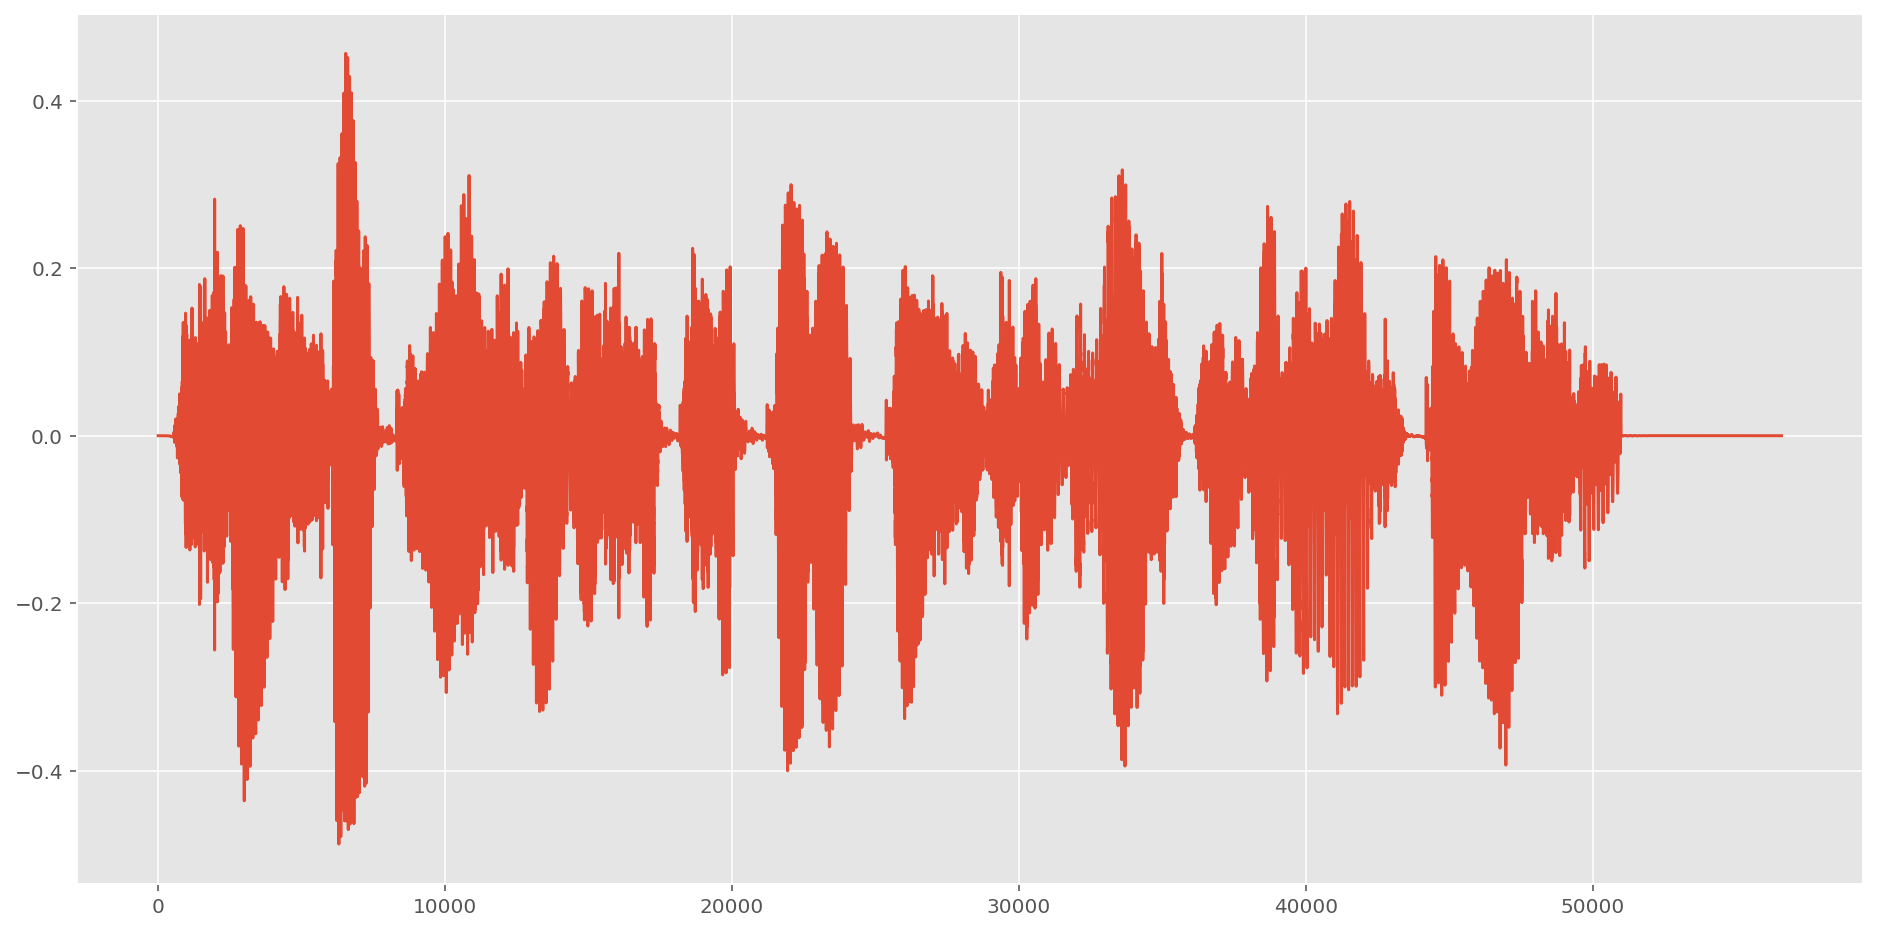

In [10]:
instance = train_dataset[0]
plt.figure(figsize=(16, 8))
plt.plot(instance['x'])

display.Audio(instance['x'], rate=dataset.SAMPLE_RATE)

Делаем паддинг: в датасете числа от $0$ до $999999$. Для работы с датасетом нам удобно, чтобы все ответы y были одинаковой длины. Если число короче шести знаков, то оставшиеся ячейки заполняем $10$:

$123456 \rightarrow y = [1,2,3,4,5,6]$

$123   \rightarrow y = [1,2,3,10,10,10]$

In [11]:
class PaddingCollator:
    def __call__(self, instances):
        batch_size = len(instances)
        x_len = torch.LongTensor([instance['x'].size(0) for instance in instances])
        y_len = torch.LongTensor([instance['y'].size(0) for instance in instances])
        path = [instance['path'] for instance in instances]

        x = torch.zeros(batch_size, max(x_len), dtype=torch.float32)
        y = torch.zeros(batch_size, max(y_len), dtype=torch.long)

        # Паддим числом 10
        y.fill_(10)

        for i, instance in enumerate(instances):
            x[i, :x_len[i]] = instance['x']
            y[i, :y_len[i]] = instance['y']

        instance = {'x': x, 'y': y, 'x_len': x_len, 'y_len': y_len, 'path': path}
        
        return instance

In [12]:
train_dataloader = DataLoader(train_dataset, 64,
                              collate_fn=PaddingCollator(), shuffle=True,
                              pin_memory=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, 32, collate_fn=PaddingCollator(),
                            pin_memory=True)

In [13]:
batch = list(islice(val_dataloader, 1))[0]
batch

{'path': ['data/numbers/train/2bc8002713.wav',
  'data/numbers/train/7bbe5803e0.wav',
  'data/numbers/train/757c64ac33.wav',
  'data/numbers/train/e21cce90a9.wav',
  'data/numbers/train/53b258bca1.wav',
  'data/numbers/train/801651b0f6.wav',
  'data/numbers/train/4a433714f7.wav',
  'data/numbers/train/d3ab5357dc.wav',
  'data/numbers/train/9d7675941a.wav',
  'data/numbers/train/8349930104.wav',
  'data/numbers/train/2e96c49dc2.wav',
  'data/numbers/train/00805abf06.wav',
  'data/numbers/train/7016357e4e.wav',
  'data/numbers/train/4b6ed00d66.wav',
  'data/numbers/train/3ff2976bea.wav',
  'data/numbers/train/320a8e447b.wav',
  'data/numbers/train/639732dc8b.wav',
  'data/numbers/train/04f1b61eec.wav',
  'data/numbers/train/fd720375a3.wav',
  'data/numbers/train/36fbf97d11.wav',
  'data/numbers/train/7f7174a9d7.wav',
  'data/numbers/train/6a210ab150.wav',
  'data/numbers/train/a8e5f49d1e.wav',
  'data/numbers/train/56228f9606.wav',
  'data/numbers/train/e4fed43b5a.wav',
  'data/numbers/t

P.S. строка тензора $x$ — это одна аудиозапись.

## Вычисление признаков
Вместо того, чтобы работать с амплитудами, — там слишком много данных — будем работать с частотами. Нарежем сигнал на кусочки, или фреймы, и для каждого фрейма делаем преобразование Фурье. Далее вычисляем его спектрограмму, а затем мел-спектрограмму.

Подробнее:

1. О преобразовании Фурье: https://proglib.io/p/fourier-transform/

2. Нарезаем сигнал на кусочки:

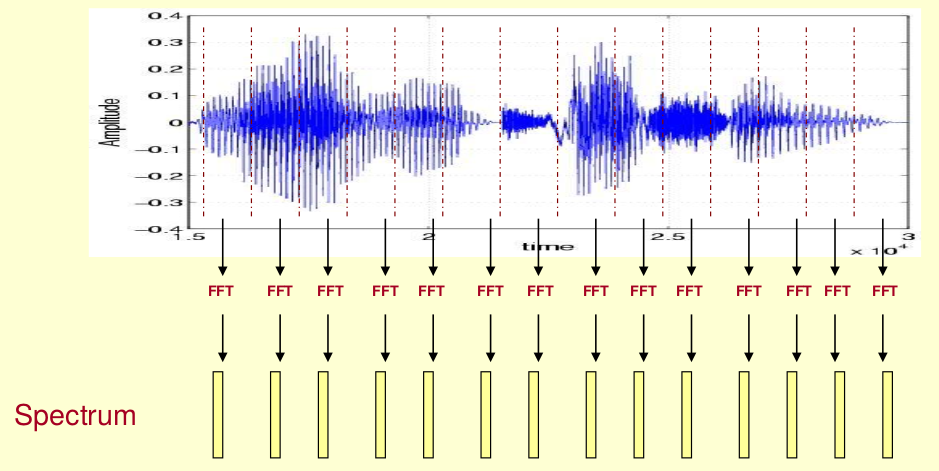

3. Для каждого кусочка получаем спектрограмму, и затем - Мел-спектрограмму.


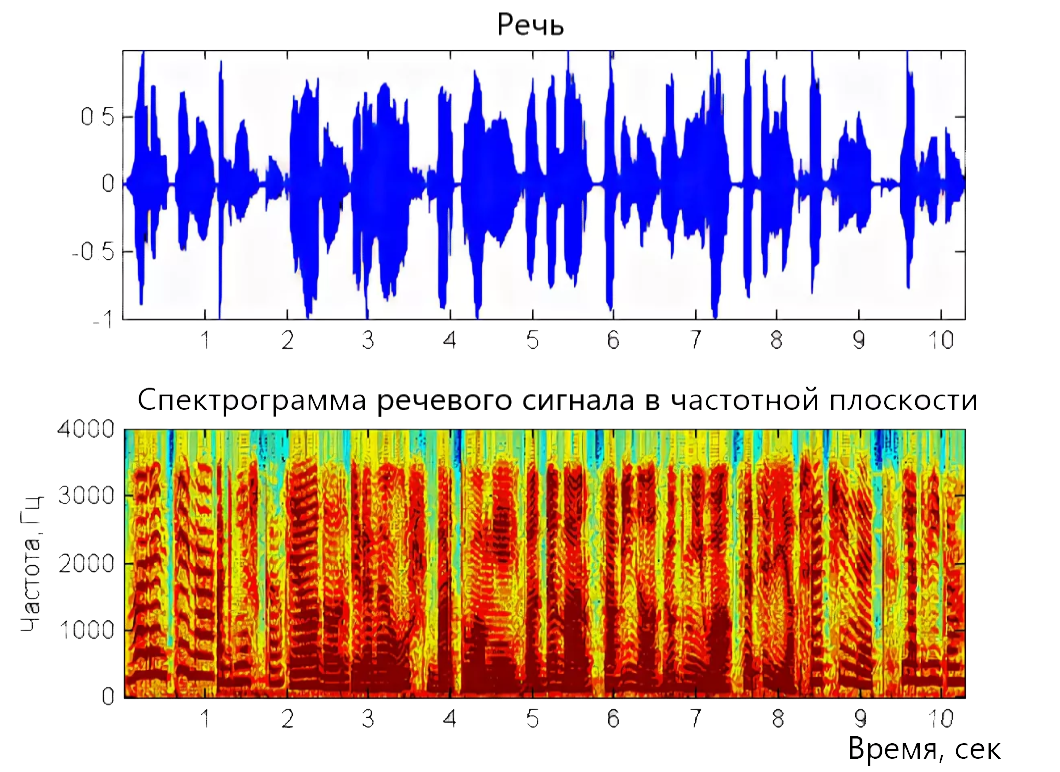

Пример получения спектрограммы по сигналу: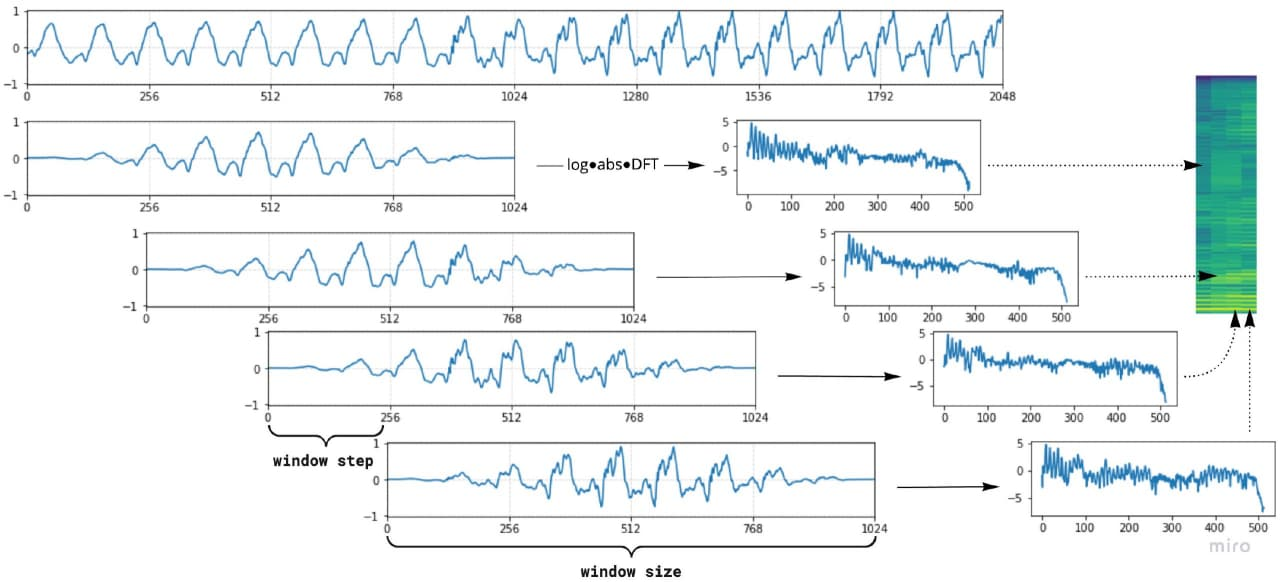

In [14]:
instance = train_dataset[31]
wav = instance['x']

In [15]:
from torchaudio.transforms import MelSpectrogram

Подробнее о параметрах мел-спектрограммы: https://rdrr.io/cran/torchaudio/man/transform_mel_spectrogram.html

In [17]:
featurizer = MelSpectrogram(sample_rate=train_dataset.dataset.SAMPLE_RATE, n_fft=1024,
                            win_length=1024, hop_length=256, n_mels=64, power=1)

def apply_compression(melspec):
    # Добавляем eps=1e-5 чтобы избежать log(0)
    return torch.log(melspec.clamp(1e-5))

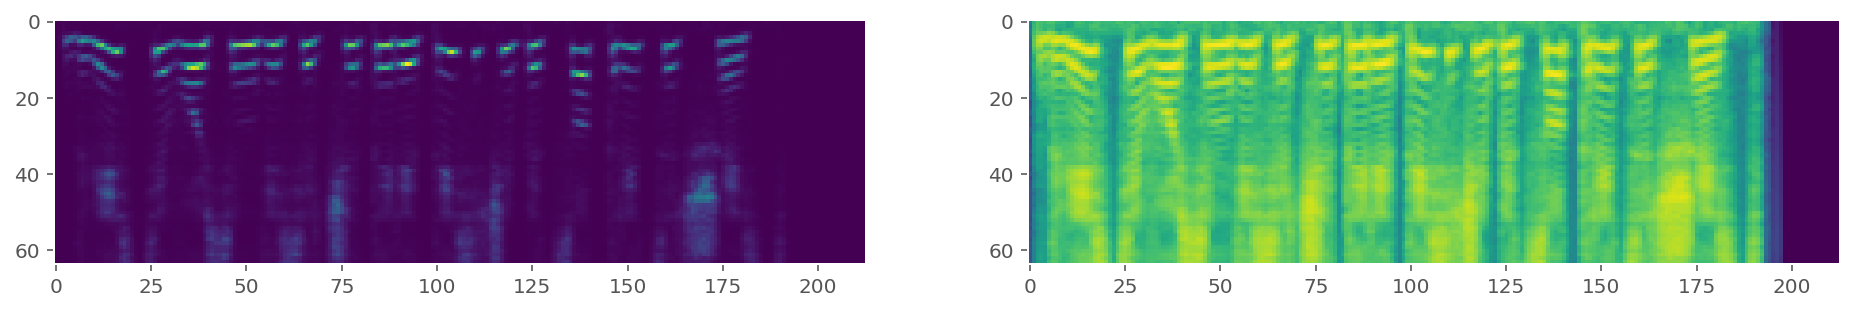

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].grid(False)
axes[0].imshow(featurizer(wav))

axes[1].grid(False)
axes[1].imshow(apply_compression(featurizer(wav)));

In [24]:
class Featurizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.featurizer = MelSpectrogram(sample_rate=train_dataset.dataset.SAMPLE_RATE,
                                         n_fft=1024, win_length=1024, hop_length=256,
                                         n_mels=64, power=1)
    
    def forward(self, x, x_len=None):
        x = self.featurizer(x)
        x = apply_compression(x)
        
        # Переводим длинну из wav размера в melSpec размер
        if x_len is not None:
            x_len = ((x_len + 1).float() / self.featurizer.hop_length).ceil().long()
            return x, x_len
        
        return x

## Модель

Напишем простую и маленькую сверточную модель на основе QuartzNet: https://arxiv.org/pdf/1910.10261.pdf.

In [25]:
class QuartzBlock(nn.Module):
    """
    Basic block of QuartzNet consisting of Separable Convolution, BatchNorm and ReLU repeating R times
    
    :param in_channels: number of input channels
    :param hidden_channels: number of hidden and output channels
    :param kernel_size: size of kernels
    :param repeat: number of repetitions of block constituents
    """
    
    def __init__(self, in_channels: int, hidden_channels: int, kernel_size: int = 33,
                 repeat: int = 4):
        super().__init__()
        
        self.repeat = repeat
        self.blocks = nn.ModuleList([nn.ModuleList([nn.Conv1d(in_channels=in_channels if i == 0 else hidden_channels,
                                                              out_channels=hidden_channels,
                                                              kernel_size=kernel_size,
                                                              groups=in_channels if i == 0 else hidden_channels,
                                                              padding=kernel_size // 2),
                                                    nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1),
                                                    nn.BatchNorm1d(hidden_channels),
                                                    nn.ReLU()])
                                     for i in range(repeat)])
        
        # convolution for residual
        self.res_conv = nn.Sequential(nn.Conv1d(in_channels, hidden_channels, kernel_size=1),
                                      nn.BatchNorm1d(hidden_channels))

    def forward(self, x):
        x_initial = x
        
        for i, block in enumerate(self.blocks):
            for j, layer in enumerate(block):
                # If not last ReLU
                if not (i == (len(self.blocks) - 1) and j ==( len(block) - 1)):
                    x = layer(x)
                else:
                    # Pass residual
                    x = x + self.res_conv(x_initial)
                    x = layer(x)
        return x



In [26]:
class DummyModel(nn.Module):
    
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        self.prenet = nn.Sequential(nn.Conv1d(in_channels, hidden_channels, 33, 
                                              padding=33 // 2, stride=2),
                                    nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1),
                                    nn.BatchNorm1d(hidden_channels),
                                    nn.ReLU())
        
        self.net = nn.Sequential(QuartzBlock(hidden_channels, hidden_channels),
                                 QuartzBlock(hidden_channels, hidden_channels * 2),
                                 nn.Conv1d(hidden_channels * 2, hidden_channels * 2, 33,
                                           padding=33 // 2, stride=2),
                                 nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=1),
                                 nn.BatchNorm1d(hidden_channels * 2),
                                 nn.ReLU(),
                                 QuartzBlock(hidden_channels * 2, hidden_channels * 4))
        
        self.classifier = nn.Sequential(nn.Conv1d(hidden_channels * 4, out_channels, kernel_size=1),
                                        nn.LogSoftmax(dim=1))
    
    def forward(self, x, x_len):
        x = self.prenet(x)
        x = self.net(x)
        return self.classifier(x), x_len // 4

# DummyModel(64, 128, 10 + 1)

## Считаем CER (character error rate)

Пример вычисления аналогичной метрики, но по словам (WER, word error rate): https://www.rev.ai/blog/how-to-calculate-word-error-rate/.

In [27]:
!pip install Levenshtein

     |████████████████████████████████| 163kB 10.8MB/s 


Для вычисления CTC-loss необходимо сделать предобработку предсказния: убрать повторяющиеся символы и blank-символы.

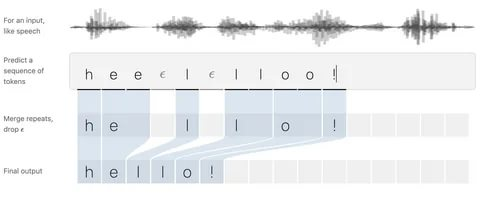

In [28]:
import Levenshtein


def ctc_decode(sequence, black_symbol=10):
    """
    Декодируем гипотезы
        1) Убираем повторяющиеся буквы
        2) Удаляем blank символы
    """
    current = []
    for i in range(0, len(sequence)):
        symbol = sequence[i]

        if i > 0 and symbol == sequence[i - 1]:
            continue

        # skip blank symbol
        if symbol == black_symbol:
            continue

        current.append(str(int(symbol)))

    text = ''.join(current)
    return text


def calculate_cer(targets, decodings, padding_value=10):
    """
    Считаем расстояние Левенштейна между предсказаниями и GT
    """
    
    cer = 0.0
    targets = targets.detach().cpu().tolist()

    pairs = []
    for target, d in zip(targets, decodings):
        target = [c for c in target if c != padding_value]
        target = "".join(map(str, target))

        decoding = ctc_decode(d.tolist())
        cer += min(1, Levenshtein.distance(target, decoding) / (len(decoding) + 1e-7))

        pairs.append(
            target + '\t\t' + decoding
        )

    return cer / len(target), pairs

## Обучение

In [29]:
class AverageMeter:
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [30]:
NUM_EPOCH = 20

model = DummyModel(64, 128, 10 + 1).to(device)
mel_featurizer = Featurizer().to(device)
criterion = nn.CTCLoss(blank=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [31]:
from IPython import display
from collections import defaultdict

In [32]:
history = defaultdict(list)

Epoch: 19
Example of prediction:  579631 -> 5796319
Example of prediction:  444707 -> 44470765
Example of prediction:  305140 -> 3051406501595159565
Example of prediction:  98797 -> 9879765
Example of prediction:  953055 -> 953055595


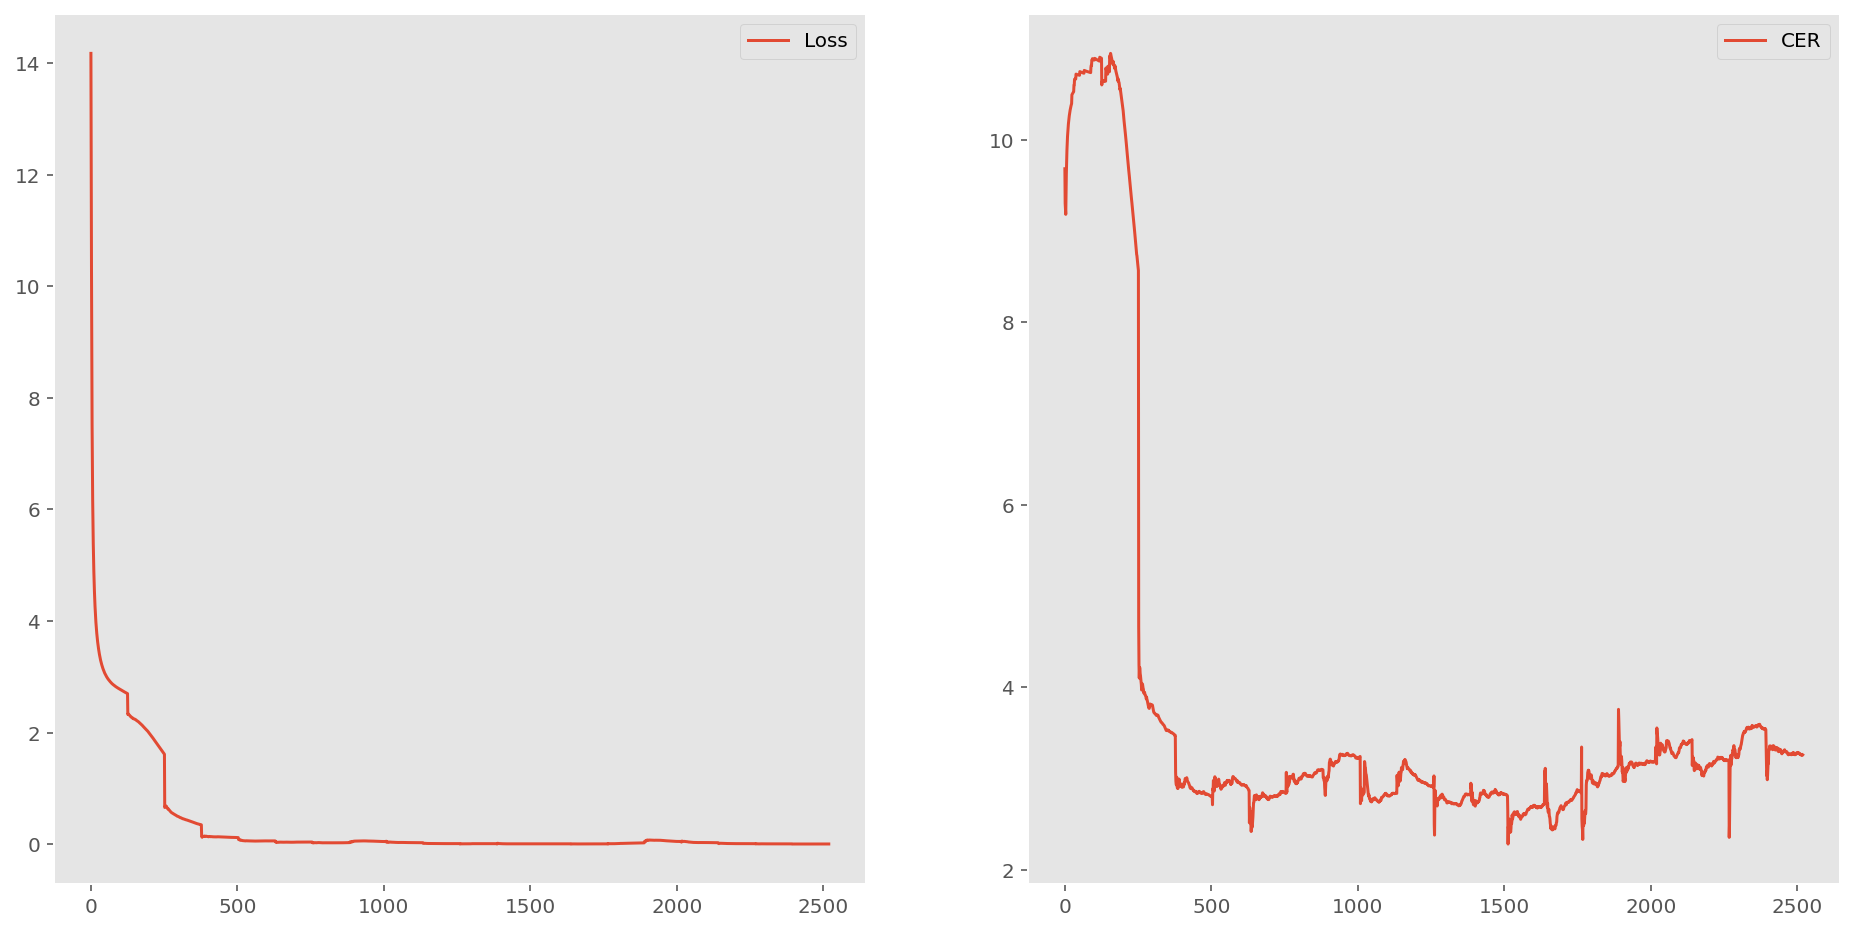

In [33]:
for epoch in range(NUM_EPOCH):

    average_cer = AverageMeter()
    average_loss = AverageMeter()
    
    for batch in train_dataloader:
        x = batch['x'].to(device)
        y = batch['y'].to(device)
        x_len = batch['x_len'].to(device)
        y_len = batch['y_len'].to(device)
        
        # Преобразуем звук в мел-спектрограмму 
        x, x_len = mel_featurizer(x, x_len)

        # Здесь можно добавить аугментацию
        
        # Пропускаем мел-спектрограмму через модель и получаем на выходе вероятности наших 
        # 11 классов, где 10 — это пропуск
        log_probs, x_len = model(x, x_len)
        
        # Меняем порядок размерностей в тензоре
        # B, C, T -> T, B, C
        log_probs = log_probs.permute(2, 0, 1)
        loss = criterion(log_probs, y, x_len, y_len)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Превращаем предсказанные вероятности в метки
        # T, B, C -> T, B -> B, T
        argmax_decoding = log_probs.detach().cpu() \
            .argmax(dim=-1).transpose(0, 1)

        
        # Считаем по тру и предсказанным меткам качество
        cer, pairs = calculate_cer(y, argmax_decoding)

        average_cer.update(cer)
        average_loss.update(loss.item())

        history['loss'].append(average_loss.avg)
        history['cer'].append(average_cer.avg)
    
    display.clear_output()
    print(f'Epoch: {epoch}')
    for i in range(5):
        print(f'Example of prediction: ', pairs[i].replace("\t\t", " -> "))
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].plot(history['loss'], label='Loss')
    axes[1].plot(history['cer'], label='CER')
    axes[0].legend(); axes[0].grid()
    axes[1].legend(); axes[1].grid()
    plt.show()

## Что дальше?
1) Добавить аугментацию SpecAug: https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/.

2) Улучшить модель. Например, еще больше уменьшить временное пространство. Сейчас мы его уменьшаем в 4 раза, но это все равно мало, так как длина GT строк 4-6.

3) Перевести цифры в буквы и учить распознавание на буквах.

4) Добавить спец символ, которым разделяем разряды — тысячи/сотни.

5) Stack more layers :)